only close price, no validation included

Using GPU for training.


[*********************100%%**********************]  1 of 1 completed


Training data shape: (1170, 60, 1), (1170,)
Test data shape: (130, 60, 1), (130,)
Epoch 1/500
37/37 [==============================] - 10s 26ms/step - loss: 0.3707
Epoch 2/500
37/37 [==============================] - 1s 22ms/step - loss: 0.3498
Epoch 3/500
37/37 [==============================] - 1s 23ms/step - loss: 0.3318
Epoch 4/500
37/37 [==============================] - 1s 22ms/step - loss: 0.3162
Epoch 5/500
37/37 [==============================] - 1s 20ms/step - loss: 0.3001
Epoch 6/500
37/37 [==============================] - 1s 20ms/step - loss: 0.2849
Epoch 7/500
37/37 [==============================] - 1s 20ms/step - loss: 0.2714
Epoch 8/500
37/37 [==============================] - 1s 21ms/step - loss: 0.2576
Epoch 9/500
37/37 [==============================] - 1s 19ms/step - loss: 0.2449
Epoch 10/500
37/37 [==============================] - 1s 20ms/step - loss: 0.2322
Epoch 11/500
37/37 [==============================] - 1s 21ms/step - loss: 0.2206
Epoch 12/500
37/37 [====

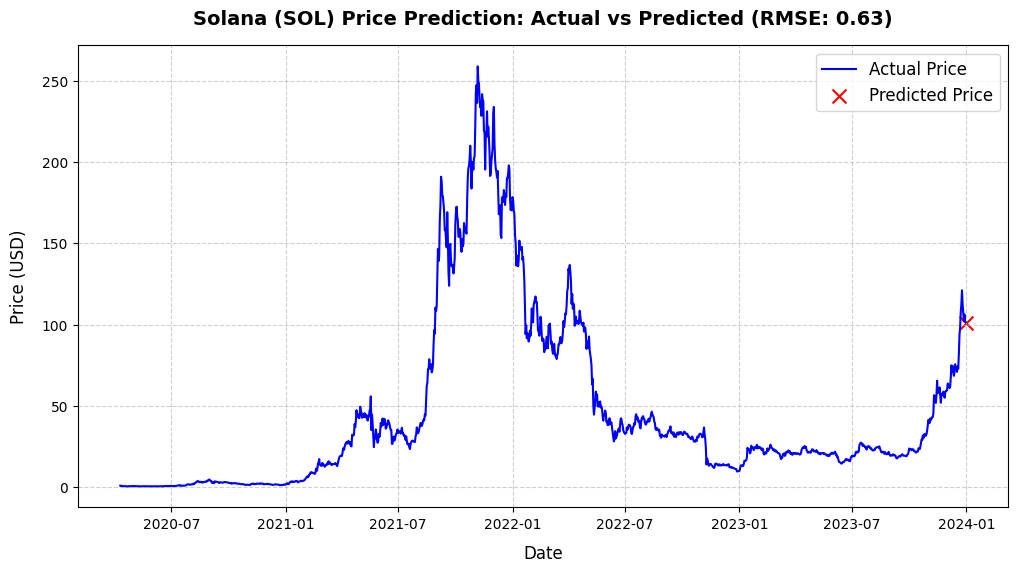

Files saved:
1. Comparison table: 'sol_comparison_table.png'
2. Test loss plot: 'sol_test_loss_plot.png'
3. Results plot: 'sol_price_prediction_with_marker.png'


In [1]:
import warnings
warnings.simplefilter("ignore")
import pandas as pd
import yfinance as yf
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization
from sklearn.metrics import mean_squared_error
from keras.regularizers import l2
import random

# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Check if TensorFlow is using a GPU
if tf.config.list_physical_devices('GPU'):
    print("Using GPU for training.")
else:
    print("No GPU detected, training on CPU.")

# Step 1: Fetch Close price data for Solana
def fetch_sol_data(start_date, end_date):
    data = yf.download('SOL-USD', start=start_date, end=end_date)
    return data[['Close']]  # Select Close price data

sol_data = fetch_sol_data('2020-01-01', '2024-01-01')

# Check if data was fetched successfully
if sol_data.empty:
    raise SystemExit("Failed to fetch data. Exiting.")

sol_data.dropna(inplace=True)  # Remove any rows with missing values

# Step 2: Preprocess data and scale features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(sol_data[['Close']])  # Only scale 'Close' price

# Step 3: Prepare the dataset for training and testing (time series split)
def create_dataset(data, time_step):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])  # Use only the 'Close' price
        y.append(data[i + time_step, 0])  # Predict 'Close' price
    return np.array(X), np.array(y)

time_step = 60
X, y = create_dataset(scaled_data, time_step)

# Reshape data for LSTM model
X = X.reshape(X.shape[0], X.shape[1], 1)  # Adjusted for single feature (Close price)

# Step 4: Split the data into training and testing sets
train_size_ratio = 0.9
train_size = int(len(X) * train_size_ratio)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Training data shape: {X_train.shape}, {y_train.shape}")
print(f"Test data shape: {X_test.shape}, {y_test.shape}")

# Step 5: Build and compile the LSTM model
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=150, return_sequences=True, input_shape=input_shape, kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())
    model.add(LSTM(units=150, return_sequences=False, kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.3))
    model.add(Dense(units=100, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dense(units=1))  # Predict the 'Close' price
    return model

model = build_lstm_model((X_train.shape[1], X_train.shape[2]))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mean_squared_error')

# Step 6: Train the model
history = model.fit(X_train, y_train, epochs=500, batch_size=32, verbose=1)

# Step 7: Evaluate the model on the test set
test_loss = model.evaluate(X_test, y_test)
print(f"Test loss: {test_loss}")

# Step 8: Prepare test data and make predictions
def make_predictions(model, data, time_step, scaler):
    test_data = data[-time_step:]
    X_test = test_data.reshape(1, time_step, 1)  # Adjust shape for prediction
    predicted_price = model.predict(X_test)
    predicted_price_rescaled = scaler.inverse_transform([[predicted_price[0][0]]])[0][0]  # Rescale predicted price
    return predicted_price_rescaled

predicted_price_rescaled = make_predictions(model, scaled_data, time_step, scaler)

# Step 9: Get actual price and create a comparison DataFrame
actual_price = sol_data['Close'][-1]  # Last actual price

comparison_df = pd.DataFrame({
    'Actual Price': [actual_price],
    'Predicted Price': [predicted_price_rescaled]
})

# Display the comparison DataFrame
print(comparison_df)

# Step 10: Calculate RMSE for the prediction
rmse = np.sqrt(mean_squared_error([actual_price], [predicted_price_rescaled]))
print(f"RMSE: {rmse}")

# Save the comparison to a CSV file
comparison_df.to_csv('actual_vs_predicted_sol_optimized.csv', index=False)

# Save table as PNG image
def save_table_as_image(data, filename, title):
    fig, ax = plt.subplots(figsize=(8, 2.5))
    ax.set_title(title, fontsize=12, fontweight='bold', pad=10)
    ax.axis('off')
    tbl = ax.table(cellText=data.values, colLabels=data.columns, cellLoc='center', loc='center')
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(10)
    tbl.scale(1.2, 1.2)
    plt.savefig(filename, bbox_inches='tight', dpi=300)
    plt.close()

save_table_as_image(comparison_df, 'sol_comparison_table.png', 'Solana (SOL) Comparison: Actual vs Predicted Price')

# Save test loss plot as PNG image with test loss in the title
def save_test_loss_plot(history, filename, title, test_loss):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.title(f"{title} (Test Loss: {test_loss:.4f})", fontsize=12, fontweight='bold')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(filename, bbox_inches='tight', dpi=300)
    plt.close()

save_test_loss_plot(history, 'sol_test_loss_plot.png', 'Solana (SOL) Training Loss Over Epochs', test_loss)

# Plot and save the prediction results
plt.figure(figsize=(12, 6))
plt.plot(sol_data.index, sol_data['Close'], label='Actual Price', color='blue')  # Actual price
plt.scatter(sol_data.index[-1], predicted_price_rescaled, color='red', label='Predicted Price', marker='x', s=100)  # Predicted price
plt.title(f'Solana (SOL) Price Prediction: Actual vs Predicted (RMSE: {rmse:.2f})', fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Date', fontsize=12, labelpad=10)
plt.ylabel('Price (USD)', fontsize=12, labelpad=10)
plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.savefig('sol_price_prediction_with_marker.png', bbox_inches='tight', dpi=300)
plt.show()

# Inform user of saved files
print("Files saved:")
print("1. Comparison table: 'sol_comparison_table.png'")
print("2. Test loss plot: 'sol_test_loss_plot.png'")
print("3. Results plot: 'sol_price_prediction_with_marker.png'")


only close price, no validation included

[*********************100%%**********************]  1 of 1 completed

Using GPU for training.
Training data shape: (1040, 60, 1), (1040,)
Validation data shape: (130, 60, 1), (130,)
Test data shape: (130, 60, 1), (130,)


Epoch 1/500
33/33 [==============================] - 6s 49ms/step - loss: 0.3745 - val_loss: 0.3546 - lr: 1.0000e-04
Epoch 2/500
33/33 [==============================] - 1s 19ms/step - loss: 0.3536 - val_loss: 0.3391 - lr: 1.0000e-04
Epoch 3/500
33/33 [==============================] - 1s 19ms/step - loss: 0.3380 - val_loss: 0.3244 - lr: 1.0000e-04
Epoch 4/500
33/33 [==============================] - 1s 18ms/step - loss: 0.3238 - val_loss: 0.3106 - lr: 1.0000e-04
Epoch 5/500
33/33 [==============================] - 1s 20ms/step - loss: 0.3094 - val_loss: 0.2971 - lr: 1.0000e-04
Epoch 6/500
33/33 [==============================] - 1s 19ms/step - loss: 0.2957 - val_loss: 0.2840 - lr: 1.0000e-04
Epoch 7/500
33/33 [==============================] - 1s 20ms/step - loss: 0.2831 - val_loss: 0.2717 - lr: 1.0000e-04
Epoch 8/500
33/33 [==============================] - 1s 20ms/step - loss: 0.2702 - val_loss: 0.2596 - lr: 1.0000e-04
Epoch 9/500
33/33 [==============================] - 1s 20ms/ste

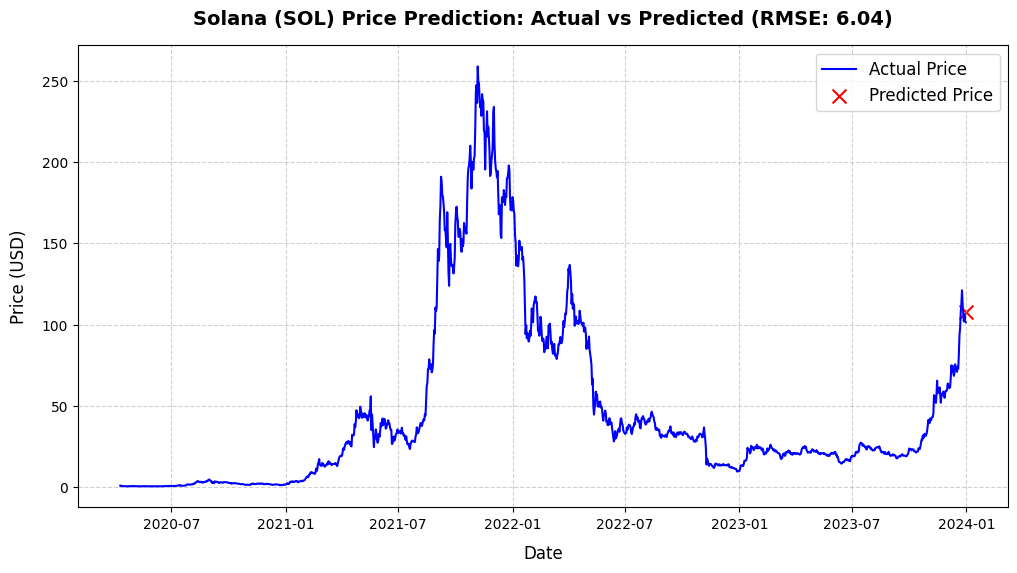

Files saved:
1. Comparison table: 'sol_comparison_table_v2.png'
2. Test loss plot: 'sol_test_loss_plot_v2.png'
3. Results plot: 'sol_price_prediction_with_marker_v2.png'


In [2]:
import warnings
warnings.simplefilter("ignore")
import pandas as pd
import yfinance as yf
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization
from sklearn.metrics import mean_squared_error
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import random

# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Check if TensorFlow is using a GPU
if tf.config.list_physical_devices('GPU'):
    print("Using GPU for training.")
else:
    print("No GPU detected, training on CPU.")

# Step 1: Fetch Close price data for Solana
def fetch_sol_data(start_date, end_date):
    data = yf.download('SOL-USD', start=start_date, end=end_date)
    return data[['Close']]  # Select Close price data

sol_data = fetch_sol_data('2020-01-01', '2024-01-01')

# Check if data was fetched successfully
if sol_data.empty:
    raise SystemExit("Failed to fetch data. Exiting.")

sol_data.dropna(inplace=True)  # Remove any rows with missing values

# Step 2: Preprocess data and scale features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(sol_data[['Close']])  # Scale only 'Close' price

# Step 3: Prepare the dataset for training and testing (time series split)
def create_dataset(data, time_step):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])  # Use only the 'Close' price
        y.append(data[i + time_step, 0])  # Predict 'Close' price
    return np.array(X), np.array(y)

time_step = 60
X, y = create_dataset(scaled_data, time_step)

# Reshape data for LSTM model
X = X.reshape(X.shape[0], X.shape[1], 1)  # Adjusted for single feature (Close price)

# Step 4: Split the data into training, validation, and testing sets (80% train, 10% validation, 10% test)
train_size = int(len(X) * 0.8)
val_size = int(len(X) * 0.1)
test_size = len(X) - train_size - val_size

X_train, X_val, X_test = X[:train_size], X[train_size:train_size + val_size], X[train_size + val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size + val_size], y[train_size + val_size:]

print(f"Training data shape: {X_train.shape}, {y_train.shape}")
print(f"Validation data shape: {X_val.shape}, {y_val.shape}")
print(f"Test data shape: {X_test.shape}, {y_test.shape}")

# Step 5: Build and compile the LSTM model
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=150, return_sequences=True, input_shape=input_shape, kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())
    model.add(LSTM(units=150, return_sequences=False, kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.3))
    model.add(Dense(units=100, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dense(units=1))  # Predict the 'Close' price
    return model

model = build_lstm_model((X_train.shape[1], X_train.shape[2]))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mean_squared_error')

# Step 6: Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Step 7: Train the model with validation data and callbacks
history = model.fit(X_train, y_train, epochs=500, batch_size=32, validation_data=(X_val, y_val),
                    callbacks=[early_stopping, reduce_lr], verbose=1)

# Step 8: Evaluate the model on the test set
test_loss = model.evaluate(X_test, y_test)
print(f"Test loss: {test_loss}")

# Step 9: Prepare test data and make predictions
def make_predictions(model, data, time_step, scaler):
    test_data = data[-time_step:]  # Use the last time_step rows for testing
    X_test = test_data.reshape(1, time_step, 1)  # Adjust shape for prediction

    # Make prediction
    predicted_price = model.predict(X_test)
    predicted_price_rescaled = scaler.inverse_transform([[predicted_price[0][0]]])[0][0]  # Rescale predicted price
    return predicted_price_rescaled

predicted_price_rescaled = make_predictions(model, scaled_data, time_step, scaler)

# Step 10: Get actual price and create a comparison DataFrame
actual_price = sol_data['Close'][-1]  # Last actual price

comparison_df = pd.DataFrame({
    'Actual Price': [actual_price],  # Single actual price
    'Predicted Price': [predicted_price_rescaled]
})

# Display the comparison DataFrame
print(comparison_df)

# Step 11: Calculate RMSE for the prediction
rmse = np.sqrt(mean_squared_error([actual_price], [predicted_price_rescaled]))
print(f"RMSE: {rmse}")

# Save the comparison to a CSV file
comparison_df.to_csv('actual_vs_predicted_sol_v2.csv', index=False)

# Save table as PNG image
def save_table_as_image(data, filename, title):
    fig, ax = plt.subplots(figsize=(8, 2.5))
    ax.set_title(title, fontsize=12, fontweight='bold', pad=10)
    ax.axis('off')
    tbl = ax.table(cellText=data.values, colLabels=data.columns, cellLoc='center', loc='center')
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(10)
    tbl.scale(1.2, 1.2)
    plt.savefig(filename, bbox_inches='tight', dpi=300)
    plt.close()

save_table_as_image(comparison_df, 'sol_comparison_table_v2.png', 'Solana (SOL) Comparison: Actual vs Predicted Prices')

# Save test loss plot as PNG image
def save_test_loss_plot(history, filename, title, test_loss):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f"{title} (Test Loss: {test_loss:.4f})", fontsize=12, fontweight='bold')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(filename, bbox_inches='tight', dpi=300)
    plt.close()

save_test_loss_plot(history, 'sol_test_loss_plot_v2.png', 'Solana (SOL) Training and Validation Loss Over Epochs', test_loss)

# Plot and save the prediction results
plt.figure(figsize=(12, 6))
plt.plot(sol_data.index, sol_data['Close'], label='Actual Price', color='blue')  # Actual price
plt.scatter(sol_data.index[-1], predicted_price_rescaled, color='red', label='Predicted Price', marker='x', s=100)  # Predicted price
plt.title(f'Solana (SOL) Price Prediction: Actual vs Predicted (RMSE: {rmse:.2f})', fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Date', fontsize=12, labelpad=10)
plt.ylabel('Price (USD)', fontsize=12, labelpad=10)
plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.savefig('sol_price_prediction_with_marker_v2.png', bbox_inches='tight', dpi=300)
plt.show()

# Inform user of saved files
print("Files saved:")
print("1. Comparison table: 'sol_comparison_table_v2.png'")
print("2. Test loss plot: 'sol_test_loss_plot_v2.png'")
print("3. Results plot: 'sol_price_prediction_with_marker_v2.png'")


multiple features, no validation included

[*********************100%%**********************]  1 of 1 completed

Using GPU for training.
Training data shape: (1170, 60, 4), (1170,)
Test data shape: (130, 60, 4), (130,)


Epoch 1/500
37/37 [==============================] - 5s 20ms/step - loss: 0.3859
Epoch 2/500
37/37 [==============================] - 1s 22ms/step - loss: 0.3659
Epoch 3/500
37/37 [==============================] - 1s 23ms/step - loss: 0.3495
Epoch 4/500
37/37 [==============================] - 1s 21ms/step - loss: 0.3371
Epoch 5/500
37/37 [==============================] - 1s 20ms/step - loss: 0.3230
Epoch 6/500
37/37 [==============================] - 1s 21ms/step - loss: 0.3100
Epoch 7/500
37/37 [==============================] - 1s 20ms/step - loss: 0.2980
Epoch 8/500
37/37 [==============================] - 1s 19ms/step - loss: 0.2864
Epoch 9/500
37/37 [==============================] - 1s 20ms/step - loss: 0.2750
Epoch 10/500
37/37 [==============================] - 1s 19ms/step - loss: 0.2635
Epoch 11/500
37/37 [==============================] - 1s 20ms/step - loss: 0.2533
Epoch 12/500
37/37 [==============================] - 1s 20ms/step - loss: 0.2429
Epoch 13/500
37/37 [=====

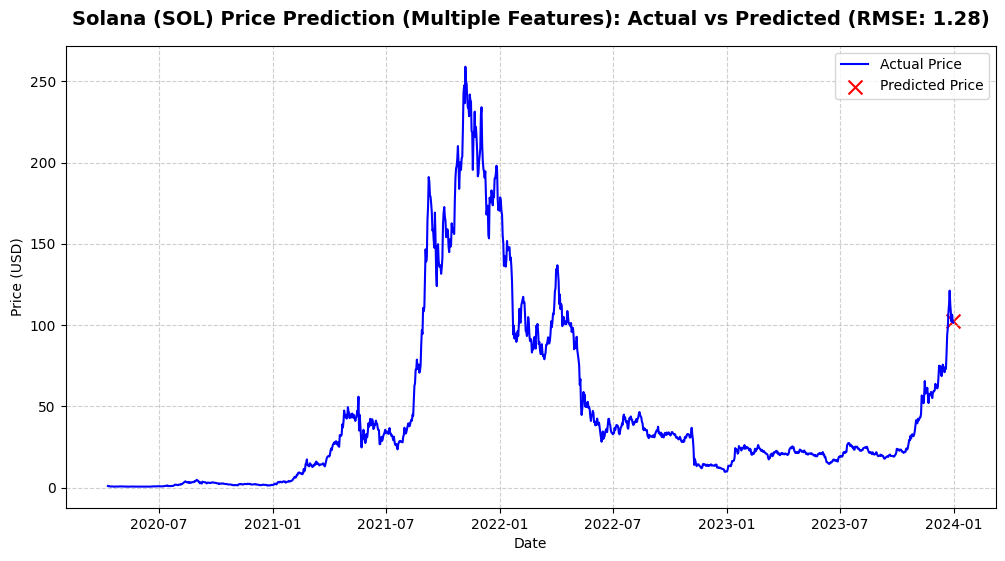

Files saved:
1. Comparison table: 'sol_comparison_table_multiple_features.png'
2. Test loss plot: 'sol_test_loss_plot_multiple_features.png'
3. Results plot: 'sol_price_prediction_multiple_features.png'


In [3]:
import warnings
warnings.simplefilter("ignore")
import pandas as pd
import yfinance as yf
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization
from sklearn.metrics import mean_squared_error
from keras.regularizers import l2
import random

# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Check if TensorFlow is using a GPU
if tf.config.list_physical_devices('GPU'):
    print("Using GPU for training.")
else:
    print("No GPU detected, training on CPU.")

# Step 1: Fetch OHLC data for Solana
def fetch_sol_data(start_date, end_date):
    data = yf.download('SOL-USD', start=start_date, end=end_date)
    return data[['Open', 'High', 'Low', 'Close']]  # Select OHLC data

sol_data = fetch_sol_data('2020-01-01', '2024-01-01')

# Check if data was fetched successfully
if sol_data.empty:
    raise SystemExit("Failed to fetch data. Exiting.")

sol_data.dropna(inplace=True)  # Remove any rows with missing values

# Step 2: Preprocess data and scale features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(sol_data)

# Step 3: Prepare the dataset for training and testing (time series split)
def create_dataset(data, time_step):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), :])  # Use OHLC data
        y.append(data[i + time_step, 3])  # Predict 'Close' price
    return np.array(X), np.array(y)

time_step = 60
X, y = create_dataset(scaled_data, time_step)

# Reshape data for LSTM model
X = X.reshape(X.shape[0], X.shape[1], X.shape[2])

# Step 4: Split the data into training and testing sets (90% train, 10% test)
train_size = int(len(X) * 0.9)  # 90-10 split
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Training data shape: {X_train.shape}, {y_train.shape}")
print(f"Test data shape: {X_test.shape}, {y_test.shape}")

# Step 5: Build and compile the LSTM model
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=150, return_sequences=True, input_shape=input_shape, kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())
    model.add(LSTM(units=150, return_sequences=False, kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.3))
    model.add(Dense(units=100, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dense(units=1))  # Predict the 'Close' price
    return model

model = build_lstm_model((X_train.shape[1], X_train.shape[2]))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mean_squared_error')

# Step 6: Train the model
history = model.fit(X_train, y_train, epochs=500, batch_size=32, verbose=1)

# Step 7: Evaluate the model on the test set
test_loss = model.evaluate(X_test, y_test)
print(f"Test loss: {test_loss}")

# Step 8: Prepare test data and make predictions
def make_predictions(model, data, time_step, scaler):
    test_data = data[-time_step:]  # Last time_step rows for testing
    X_test = test_data.reshape(1, time_step, data.shape[1])  # Adjust shape for prediction

    # Make prediction
    predicted_price = model.predict(X_test)

    # Rescale predicted price using the scaler for the 'Close' price only
    predicted_price_rescaled = scaler.inverse_transform(
        np.concatenate((np.zeros((1, 3)), predicted_price), axis=1)
    )[:, 3]  # Rescale and extract 'Close' price
    return predicted_price_rescaled[0]

predicted_price_rescaled = make_predictions(model, scaled_data, time_step, scaler)

# Step 9: Get actual price and create a comparison DataFrame
actual_price = sol_data['Close'][-1]  # Last actual price

comparison_df = pd.DataFrame({
    'Actual Price': [actual_price],  # Single actual price
    'Predicted Price': [predicted_price_rescaled]
})

# Display the comparison DataFrame
print(comparison_df)

# Step 10: Calculate RMSE for the prediction
rmse = np.sqrt(mean_squared_error([actual_price], [predicted_price_rescaled]))
print(f"RMSE: {rmse}")

# Save the comparison to a CSV file
comparison_df.to_csv('sol_actual_vs_predicted_multiple_features.csv', index=False)

# Save table as PNG image
def save_table_as_image(data, filename, title):
    fig, ax = plt.subplots(figsize=(8, 2.5))
    ax.set_title(title, fontsize=12, fontweight='bold', pad=10)
    ax.axis('off')
    tbl = ax.table(cellText=data.values, colLabels=data.columns, cellLoc='center', loc='center')
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(10)
    tbl.scale(1.2, 1.2)
    plt.savefig(filename, bbox_inches='tight', dpi=300)
    plt.close()

save_table_as_image(comparison_df, 'sol_comparison_table_multiple_features.png', 'Solana (SOL) Actual vs Predicted Prices')

# Save test loss plot as PNG image
def save_test_loss_plot(history, filename, title, test_loss):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.title(f"{title} (Test Loss: {test_loss:.4f})", fontsize=12, fontweight='bold')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(filename, bbox_inches='tight', dpi=300)
    plt.close()

save_test_loss_plot(history, 'sol_test_loss_plot_multiple_features.png', 'Solana (SOL) Training Loss Over Epochs', test_loss)

# Plot and save the prediction results
plt.figure(figsize=(12, 6))
plt.plot(sol_data['Close'], label='Actual Price', color='blue')  # Actual price
plt.scatter(sol_data.index[-1], predicted_price_rescaled, color='red', label='Predicted Price', marker='x', s=100)  # Predicted price
plt.title(f'Solana (SOL) Price Prediction (Multiple Features): Actual vs Predicted (RMSE: {rmse:.2f})', fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.legend()
plt.savefig('sol_price_prediction_multiple_features.png', bbox_inches='tight', dpi=300)
plt.show()

# Inform user of saved files
print("Files saved:")
print("1. Comparison table: 'sol_comparison_table_multiple_features.png'")
print("2. Test loss plot: 'sol_test_loss_plot_multiple_features.png'")
print("3. Results plot: 'sol_price_prediction_multiple_features.png'")


multiple features, validation included

[*********************100%%**********************]  1 of 1 completed

Using GPU for training.
Training data shape: (1040, 60, 4), (1040,)
Validation data shape: (130, 60, 4), (130,)
Test data shape: (130, 60, 4), (130,)


Epoch 1/500
33/33 [==============================] - 5s 46ms/step - loss: 0.3847 - val_loss: 0.3644 - lr: 1.0000e-04
Epoch 2/500
33/33 [==============================] - 1s 20ms/step - loss: 0.3667 - val_loss: 0.3531 - lr: 1.0000e-04
Epoch 3/500
33/33 [==============================] - 1s 20ms/step - loss: 0.3540 - val_loss: 0.3409 - lr: 1.0000e-04
Epoch 4/500
33/33 [==============================] - 1s 20ms/step - loss: 0.3410 - val_loss: 0.3291 - lr: 1.0000e-04
Epoch 5/500
33/33 [==============================] - 1s 20ms/step - loss: 0.3280 - val_loss: 0.3177 - lr: 1.0000e-04
Epoch 6/500
33/33 [==============================] - 1s 20ms/step - loss: 0.3168 - val_loss: 0.3062 - lr: 1.0000e-04
Epoch 7/500
33/33 [==============================] - 1s 19ms/step - loss: 0.3059 - val_loss: 0.2951 - lr: 1.0000e-04
Epoch 8/500
33/33 [==============================] - 1s 20ms/step - loss: 0.2948 - val_loss: 0.2844 - lr: 1.0000e-04
Epoch 9/500
33/33 [==============================] - 1s 19ms/ste

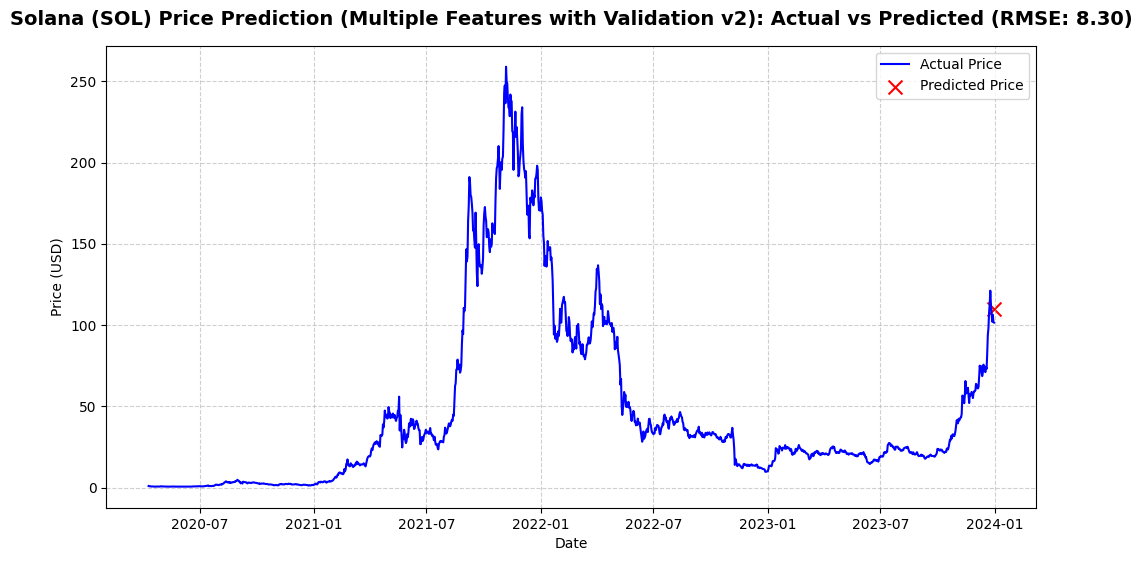

Files saved:
1. Comparison table: 'sol_comparison_table_multiple_features_with_val_v2.png'
2. Test loss plot: 'sol_test_loss_plot_multiple_features_with_val_v2.png'
3. Results plot: 'sol_price_prediction_multiple_features_with_val_v2.png'


In [4]:
import warnings
warnings.simplefilter("ignore")
import pandas as pd
import yfinance as yf
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization
from sklearn.metrics import mean_squared_error
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import random

# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Check if TensorFlow is using a GPU
if tf.config.list_physical_devices('GPU'):
    print("Using GPU for training.")
else:
    print("No GPU detected, training on CPU.")

# Step 1: Fetch OHLC data for Solana
def fetch_sol_data(start_date, end_date):
    data = yf.download('SOL-USD', start=start_date, end=end_date)
    return data[['Open', 'High', 'Low', 'Close']]  # Select OHLC data

sol_data = fetch_sol_data('2020-01-01', '2024-01-01')

# Check if data was fetched successfully
if sol_data.empty:
    raise SystemExit("Failed to fetch data. Exiting.")

sol_data.dropna(inplace=True)  # Remove any rows with missing values

# Step 2: Preprocess data and scale features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(sol_data)

# Step 3: Prepare the dataset for training, validation, and testing (time series split)
def create_dataset(data, time_step):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), :])  # Use OHLC data
        y.append(data[i + time_step, 3])  # Predict 'Close' price
    return np.array(X), np.array(y)

time_step = 60
X, y = create_dataset(scaled_data, time_step)

# Reshape data for LSTM model
X = X.reshape(X.shape[0], X.shape[1], X.shape[2])

# Split into training (80%), validation (10%), and testing (10%)
train_size = int(len(X) * 0.8)
val_size = int(len(X) * 0.1)
X_train, X_val, X_test = X[:train_size], X[train_size:train_size + val_size], X[train_size + val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size + val_size], y[train_size + val_size:]

print(f"Training data shape: {X_train.shape}, {y_train.shape}")
print(f"Validation data shape: {X_val.shape}, {y_val.shape}")
print(f"Test data shape: {X_test.shape}, {y_test.shape}")

# Step 4: Build and compile the LSTM model
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=150, return_sequences=True, input_shape=input_shape, kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())
    model.add(LSTM(units=150, return_sequences=False, kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.3))
    model.add(Dense(units=100, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dense(units=1))  # Predict the 'Close' price
    return model

model = build_lstm_model((X_train.shape[1], X_train.shape[2]))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mean_squared_error')

# Step 5: Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Step 6: Train the model with validation data and callbacks
history = model.fit(X_train, y_train, epochs=500, batch_size=32, validation_data=(X_val, y_val),
                    callbacks=[early_stopping, reduce_lr], verbose=1)

# Step 7: Evaluate the model on the test set
test_loss = model.evaluate(X_test, y_test)
print(f"Test loss: {test_loss}")

# Step 8: Prepare test data and make predictions
def make_predictions(model, data, time_step, scaler):
    test_data = data[-time_step:]  # Last time_step rows for testing
    X_test = test_data.reshape(1, time_step, data.shape[1])  # Adjust shape for prediction

    # Make prediction
    predicted_price = model.predict(X_test)

    # Rescale predicted price using the scaler for the 'Close' price only
    predicted_price_rescaled = scaler.inverse_transform(
        np.concatenate((np.zeros((1, 3)), predicted_price), axis=1)
    )[:, 3]  # Rescale and extract 'Close' price
    return predicted_price_rescaled[0]

predicted_price_rescaled = make_predictions(model, scaled_data, time_step, scaler)

# Step 9: Get actual price and create a comparison DataFrame
actual_price = sol_data['Close'][-1]  # Last actual price

comparison_df = pd.DataFrame({
    'Actual Price': [actual_price],  # Single actual price
    'Predicted Price': [predicted_price_rescaled]
})

# Display the comparison DataFrame
print(comparison_df)

# Step 10: Calculate RMSE for the prediction
rmse = np.sqrt(mean_squared_error([actual_price], [predicted_price_rescaled]))
print(f"RMSE: {rmse}")

# Save the comparison to a CSV file
comparison_df.to_csv('sol_actual_vs_predicted_multiple_features_with_val_v2.csv', index=False)

# Save table as PNG image
def save_table_as_image(data, filename, title):
    fig, ax = plt.subplots(figsize=(8, 2.5))
    ax.set_title(title, fontsize=12, fontweight='bold', pad=10)
    ax.axis('off')
    tbl = ax.table(cellText=data.values.round(2), colLabels=data.columns, cellLoc='center', loc='center')
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(10)
    tbl.scale(1.2, 1.2)
    plt.savefig(filename, bbox_inches='tight', dpi=300)
    plt.close()

save_table_as_image(comparison_df, 'sol_comparison_table_multiple_features_with_val_v2.png', 'Solana (SOL) Actual vs Predicted Prices')

# Save test loss plot as PNG image
def save_test_loss_plot(history, filename, title, test_loss):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f"{title} (Test Loss: {test_loss:.4f})", fontsize=12, fontweight='bold')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(filename, bbox_inches='tight', dpi=300)
    plt.close()

save_test_loss_plot(history, 'sol_test_loss_plot_multiple_features_with_val_v2.png', 'Solana (SOL) Training and Validation Loss Over Epochs', test_loss)

# Plot and save the prediction results
plt.figure(figsize=(12, 6))
plt.plot(sol_data['Close'], label='Actual Price', color='blue')  # Actual price
plt.scatter(sol_data.index[-1], predicted_price_rescaled, color='red', label='Predicted Price', marker='x', s=100)  # Predicted price
plt.title(f'Solana (SOL) Price Prediction (Multiple Features with Validation v2): Actual vs Predicted (RMSE: {rmse:.2f})', fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.legend()
plt.savefig('sol_price_prediction_multiple_features_with_val_v2.png', bbox_inches='tight', dpi=300)
plt.show()

# Inform user of saved files
print("Files saved:")
print("1. Comparison table: 'sol_comparison_table_multiple_features_with_val_v2.png'")
print("2. Test loss plot: 'sol_test_loss_plot_multiple_features_with_val_v2.png'")
print("3. Results plot: 'sol_price_prediction_multiple_features_with_val_v2.png'")
